In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import plotly.graph_objects as go
import scipy.spatial as ss
import scipy.interpolate as it
import time
from sklearn.metrics import mean_squared_error, mean_squared_log_error
# from sklearn.neighbors import KDTree

In [4]:
# Fields.csv
# r  |  z  |  Er | Ez
# Electric current = info[0] 
# Distance scaling to meter = multiply by info[1] 
# Electric Field (Er, Ez) scaling to V/m = multiply by info[2]
# Velocity scaling to m/s = multiply by info[3];
# Extractor voltage = info[6]; 

#EXTRACTOR_DIST = info[10]; //extractor distance
#EXTRACTOR_APETURE_DIA = info[11]; //extractor width
#EXTRACTOR_THICKNESS = info[12]; //extractor thickness

info = np.loadtxt('E_Field/info.txt')
convert_dist=info[1] 
convert_E=info[2]
convert_vel=info[3]



# Load the csv file
df = pd.read_csv('E_Field/Fields.csv')

# Convert the DataFrame to a numpy array
Field = df.values
r=Field[:,0]*convert_dist
z=Field[:,1]*convert_dist
Er=Field[:,2]*convert_E
Ez=Field[:,3]*convert_E


In [5]:
print('max r=',np.max(r))
print('max z=',np.max(z))
print('max Er=',(np.max(Er)))
print('max Ez=',(np.max(Ez)))

print('min r=',np.min(r))
print('min z=',np.min(z))
print('min Er=',(np.min(Er)))
print('min Ez=',(np.min(Ez)))

max r= 0.00030000000000000003
max z= 0.0007000000000000001
max Er= 627206342.7222513
max Ez= 1020663871.9052938
min r= 0.0
min z= -0.00015000000000000001
min Er= -1922061.4984387478
min Ez= -4538210.266731723


In [6]:

def create_tree(r,z):
    points_array = np.c_[r.ravel(),z.ravel()]
    required_kD_tree = ss.KDTree(points_array)
    
    return required_kD_tree

def interpolate_tree(tree, points_of_interest, Er, Ez):
    Er_val = np.empty([points_of_interest.shape[0],])
    Ez_val = np.empty([points_of_interest.shape[0],])
    for point in points_of_interest:
        d, i = tree.query(point,k=3, eps=10e-6)
        factor = d[0] + d[1] + d[2]
        # print((Er[i[0]]* (1-d[0]/factor) + Er[i[1]]* (1-d[1]/factor) + Er[i[2]]* (1-d[2]/factor)))
        np.append(Er_val, (Er[i[0]]* (1-d[0]/factor) + Er[i[1]]* (1-d[1]/factor) + Er[i[2]]* (1-d[2]/factor)))
        np.append(Ez_val, (Ez[i[0]]* (1-d[0]/factor) + Ez[i[1]]* (1-d[1]/factor) + Ez[i[2]]* (1-d[2]/factor)))
        return np.column_stack((Er_val,Ez_val))


In [7]:
#create the Delaunay Triangulation

def create_triangle(r,z):
    data_points = np.column_stack((r,z))
    triangle = ss.Delaunay(data_points, furthest_site=False, incremental=False, qhull_options=None)

    return triangle

def interpolate_triangle(triangle, points_of_interest, Er, Ez):
    Er_val = np.empty([points_of_interest.shape[0],])
    Ez_val = np.empty([points_of_interest.shape[0],])
    E_array= np.vstack((Er.flatten(), Ez.flatten())).T
    # for point in points_of_interest:
            
    interpolator = it.LinearNDInterpolator(triangle, E_array, rescale = False)
    Er_Ez_vals = interpolator(points_of_interest)
    # Ez_interpolator = it.LinearNDInterpolator(triangle, Ez, rescale = False)
    # Ez_val = Ez_interpolator(points_of_interest)

    return Er_Ez_vals


In [13]:
# Preprocess Data

info = np.loadtxt('E_Field/info.txt')
convert_dist=info[1] 
convert_E=info[2]
convert_vel=info[3]


# Load the csv file
df = pd.read_csv('E_Field/Fields.csv')

# Convert the DataFrame to a numpy array
Field = df.values
r=Field[:,0]*convert_dist
z=Field[:,1]*convert_dist
Er=Field[:,2]*convert_E
Ez=Field[:,3]*convert_E

In [14]:
# 5-fold cross validation

def split_dataset(dataset, no_of_sections, section_no, total_size):
    # section will be 1 if you want the first section, 2 if you want second etc

    return dataset[int(((section_no-1)/no_of_sections)*total_size): int((section_no/no_of_sections)*total_size)], np.arange(int(((section_no-1)/no_of_sections)*total_size), (int((section_no/no_of_sections)*total_size)-1), 1)


def check_algorithms(r,z,Er,Ez,ratio, algorithm_type):
    # Split the data

    size = len(r)
    dataset_r, r_indices = split_dataset(r, 5, ratio, size)
    dataset_z, z_indices = split_dataset(z, 5, ratio, size)
    r_training_data = np.delete(r, r_indices, 0)
    z_training_data = np.delete(z, z_indices, 0)

    actual_Er = split_dataset(Er, 5, ratio, size)[0]
    actual_Ez = split_dataset(Ez, 5, ratio, size)[0]
    actual_values = np.column_stack((actual_Er,actual_Ez))

    Er_training_data = np.delete(Er, r_indices, 0)
    Ez_training_data = np.delete(Ez, r_indices, 0)

    # Check algorithm type and call the required function

    if "Tree" in algorithm_type or "tree" in algorithm_type: 
        testing_tree = create_tree(r_training_data,z_training_data)
        points_array = np.c_[dataset_r.ravel(), dataset_z.ravel()]
        start_time = time.time()
        predictions = interpolate_tree(testing_tree, points_array, Er_training_data, Ez_training_data)
        end_time = time.time()
        time_taken = (end_time-start_time)
    elif "Triangle" in algorithm_type or "triangle" in algorithm_type:
        testing_triangle = create_triangle(r_training_data,z_training_data)
        points_array = np.c_[dataset_r.ravel(), dataset_z.ravel()]
        start_time = time.time()
        predictions = interpolate_triangle(testing_triangle, points_array, Er_training_data, Ez_training_data)
        end_time = time.time()
        time_taken = (end_time-start_time)
    
    # Account for Nan values

    if np.count_nonzero(np.isnan(predictions))!=0:
        indices_nan_0 = np.where(np.isnan(predictions[:, 0]))
        indices_nan_1 = np.where(np.isnan(predictions[:, 1]))
        nan_indices = np.unique(np.concatenate((indices_nan_0[0], indices_nan_1[0])))
        predictions= np.delete(predictions, nan_indices, axis = 0 )
        actual_values = np.delete(actual_values, nan_indices, axis = 0)

    # Calculate error

    absolute_error = np.abs(predictions - actual_values)
    epsilon = 1e-7
    relative_error = absolute_error / (np.abs(actual_values) + epsilon)
    count = np.sum(relative_error > 1)
    percentage_error = count/np.size(relative_error)

    # Assign algorithm a score based on error and time
    algorithm_score = 5000*(1-percentage_error) + 100/time_taken

    return algorithm_score

# Testing Tree algorithm

tree_scores = []
tree_scores.append(check_algorithms(r, z, Er, Ez, 1, "tree"))
tree_scores.append(check_algorithms(r, z, Er, Ez, 2, "tree"))
tree_scores.append(check_algorithms(r, z, Er, Ez, 3, "tree"))
tree_scores.append(check_algorithms(r, z, Er, Ez, 4, "tree"))
tree_scores.append(check_algorithms(r, z, Er, Ez, 5, "tree"))
print(tree_scores)

# Testing Triangle algorithm

triangle_scores = []
triangle_scores.append(check_algorithms(r, z, Er, Ez, 1, "triangle"))
triangle_scores.append(check_algorithms(r, z, Er, Ez, 2, "triangle"))
triangle_scores.append(check_algorithms(r, z, Er, Ez, 3, "triangle"))
triangle_scores.append(check_algorithms(r, z, Er, Ez, 4, "triangle"))
triangle_scores.append(check_algorithms(r, z, Er, Ez, 5, "triangle"))
print(triangle_scores)










[110567.74790623052, 425270.8604730832, 279808.80595317314, 426660.1488579766, 55251.583335729236]
[5084.698460755357, 5073.948425711944, 5007.909010299269, 5035.205525479007, 4259.8894448222445]


## 1- Check the Mesh

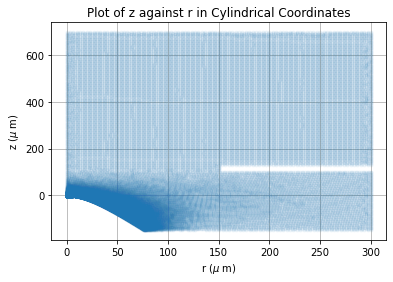

In [11]:
plt.figure()
plt.plot(r*1e6, z*1e6, '.',alpha=0.05)
plt.xlabel('r ($\mu$ m)')
plt.ylabel('z ($\mu$ m)')
plt.title('Plot of z against r in Cylindrical Coordinates')
plt.grid(True)
plt.show()

## 2- Probability distribution

In [12]:
prob = np.loadtxt('E_field/prob.txt')
prob = np.loadtxt('E_field/prob.txt')
prob = np.loadtxt('E_field/prob.txt')
prob = np.loadtxt('E_field/prob.txt')
prob = np.loadtxt('E_field/prob.txt')
